# This is the speaking part of GenIELTS, a phonemes error detection system

### First we should convert audio input to a text

In [24]:
import torch
import torchaudio
from transformers import AutoTokenizer, AutoModelForSpeechSeq2Seq, AutoProcessor, BitsAndBytesConfig
import librosa
import numpy as np
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/whisper-small.en"

# Load processor
processor = AutoProcessor.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)


model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id)
model.to(device)



WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [26]:
def audio_to_text(audio_file_path, sample_rate=16000):
    """
    Convert audio file to text using Whisper model correctly
    
    Args:
        audio_file_path (str): Path to the audio file
        sample_rate (int): Target sample rate for the model
    
    Returns:
        str: Transcribed text
    """
    # Load and preprocess audio
    audio, sr = librosa.load(audio_file_path, sr=sample_rate)
    
    # Process audio with the model's processor
    inputs = processor(audio, sampling_rate=sample_rate, return_tensors="pt")
    
    # Move inputs to device
    if torch.cuda.is_available():
        inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate transcription using the proper generation method
    with torch.no_grad():
        # Use model.generate() instead of direct forward pass
        generated_ids = model.generate(
            inputs["input_features"],
            max_length=448,
            do_sample=False,
            temperature=0.0,
            return_timestamps=False
        )
    
    # Decode the generated IDs to text
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return transcription

def audio_to_text_chunked(audio_file_path, sample_rate=16000, chunk_length_s=30):
    """
    Convert audio file to text using Whisper model with chunking.
    
    Args:
        audio_file_path (str): Path to the audio file
        sample_rate (int): Target sample rate for the model
        chunk_length_s (int): Length of audio chunks in seconds
    
    Returns:
        str: Transcribed text
    """
    # Load audio
    audio, sr = librosa.load(audio_file_path, sr=sample_rate)
    
    chunk_size = chunk_length_s * sample_rate
    num_chunks = (len(audio) + chunk_size - 1) // chunk_size
    
    full_transcription = ""
    
    for i in tqdm(range(num_chunks), desc=f"Chunking {audio_file_path}"):
        start = i * chunk_size
        end = start + chunk_size
        chunk = audio[start:end]
        
        # Process audio with the model's processor
        inputs = processor(chunk, sampling_rate=sample_rate, return_tensors="pt")

        # Move inputs to device
        if torch.cuda.is_available():
            inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate transcription using the proper generation method
        with torch.no_grad():
            generated_ids = model.generate(
                inputs["input_features"],
                max_length=448,
                do_sample=False,
                temperature=0.0,
                return_timestamps=False
            )

        # Decode the generated IDs to text
        transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        full_transcription += transcription + " "
        
    return full_transcription.strip()

In [27]:
# Alternative approach using Transformers pipeline (more robust)
from transformers import pipeline

def audio_to_text_pipeline(audio_file_path, chunk_length_s=30):
    """
    Convert audio file to text using Transformers pipeline (most reliable method)
    
    Args:
        audio_file_path (str): Path to the audio file
        chunk_length_s (int): Length of audio chunks in seconds
    
    Returns:
        str: Transcribed text
    """
    try:
        # Create a speech recognition pipeline
        pipe = pipeline(
            "automatic-speech-recognition",
            model=model_id,
            device=0 if torch.cuda.is_available() else -1,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            chunk_length_s=chunk_length_s,
            return_timestamps=True  # Enable timestamps for better alignment
        )
        
        # Process the audio file
        result = pipe(audio_file_path)
        
        # Extract text from result
        if isinstance(result, dict):
            return result.get("text", "")
        elif isinstance(result, list):
            return " ".join([chunk.get("text", "") for chunk in result])
        else:
            return str(result)
            
    except Exception as e:
        print(f"Pipeline method failed: {e}")
        print("Falling back to manual method...")
        return audio_to_text_chunked(audio_file_path, chunk_length_s=chunk_length_s)

def audio_to_text_simple(audio_file_path):
    """
    Simple audio to text conversion using librosa and basic processing
    
    Args:
        audio_file_path (str): Path to the audio file
    
    Returns:
        str: Transcribed text
    """
    try:
        # Try pipeline method first (most reliable)
        return audio_to_text_pipeline(audio_file_path)
    except Exception as e:
        print(f"Pipeline failed, trying chunked method: {e}")
        try:
            # Fallback to chunked method
            return audio_to_text_chunked(audio_file_path)
        except Exception as e2:
            print(f"Chunked method failed: {e2}")
            # Final fallback
            return audio_to_text(audio_file_path)

In [28]:
# Test audio transcription functionality
print("Testing Audio Transcription Methods")
print("=" * 50)

# Check if audio file exists
import os
audio_files = ["/kaggle/input/audiotest/artest.wav"]
available_files = [f for f in audio_files if os.path.exists(f)]

if available_files:
    test_file = available_files[0]
    print(f"Testing with: {test_file}")
    
    try:
        # Test the simple method
        print("\n1. Testing audio_to_text_simple()...")
        transcript = audio_to_text_simple(test_file)
        print(f"✓ Success! Transcript: '{transcript[:100]}...'")
        
    except Exception as e:
        print(f"❌ Error in audio_to_text_simple: {e}")
        
        try:
            # Test pipeline method directly
            print("\n2. Testing pipeline method...")
            transcript = audio_to_text_pipeline(test_file)
            print(f"✓ Pipeline success! Transcript: '{transcript[:100]}...'")
            
        except Exception as e2:
            print(f"❌ Pipeline error: {e2}")
            
            try:
                # Test basic method
                print("\n3. Testing basic method...")
                transcript = audio_to_text(test_file)
                print(f"✓ Basic method success! Transcript: '{transcript[:100]}...'")
                
            except Exception as e3:
                print(f"❌ All methods failed: {e3}")
                print("Please check your model and audio file setup.")
                
else:
    print("❌ No audio files found for testing.")
    print("Available files in directory:", os.listdir("."))

print("=" * 50)

Testing Audio Transcription Methods
Testing with: /kaggle/input/audiotest/artest.wav

1. Testing audio_to_text_simple()...


Device set to use cuda:0


✓ Success! Transcript: ' Okay, so you're gonna say these words in an Arabic accent. Ready? Okay. World. World. Next. Next. Y...'


In [ ]:
import nltk
import re

# Download CMUdict if not already present
nltk.download('cmudict')
from nltk.corpus import cmudict

def parse_cmudict():
    """
    Parses the CMUdict into a dictionary mapping words to phoneme lists.
    """
    d = cmudict.dict()
    # Convert ARPAbet phonemes to a string format (space-separated)
    lexicon = {word: [' '.join(phonemes) for phonemes in prons] for word, prons in d.items()}
    return lexicon

# Parse the CMUdict
cmudict_lexicon = parse_cmudict()


In [30]:
!pip install g2p_en

In [ ]:

from g2p_en import G2p

# Initialize the G2P converter
g2p = G2p()

def alternative_g2p(word):
    """
    Alternative G2P using g2p-en library (doesn't require espeak).
    """
    try:
        phonemes = g2p(word)
        # Convert to a format similar to cmudict
        return ' '.join(phonemes)
    except Exception as e:
        print(f"G2P failed for '{word}': {e}")
        return word.lower()

def get_phonemes_enhanced(word, lexicon):
    """
    Enhanced phoneme lookup with multiple fallback options.
    """
    word = word.lower()
    if word in lexicon:
        return lexicon[word][0]  # Return the first pronunciation from CMUdict
    else:
        # Try alternative G2P first
        try:
            return alternative_g2p(word)
        except Exception as e:
            print(f"Alternative G2P failed for '{word}': {e}")
            # Final fallback - simple phonetic approximation
            return word.lower()

In [ ]:
def transcript_to_phonemes(transcript, lexicon):
    """
    Convert transcript text to phonemes and print the results.
    
    Args:
        transcript (str): The transcribed text from audio
        lexicon (dict): The phoneme dictionary (cmudict_lexicon)
    """
    # Clean and split the transcript into words
    words = re.sub(r'[^\w\s]', '', transcript.lower()).split()
    
    print(f"Original transcript: {transcript}")
    print(f"Number of words: {len(words)}")
    print("-" * 60)
    
    phoneme_results = []
    
    for i, word in enumerate(words, 1):
        phonemes = get_phonemes_enhanced(word, lexicon)
        phoneme_results.append((word, phonemes))
        print(f"{i:2d}. Word: '{word}' -> Phonemes: [{phonemes}]")
    
    print("-" * 60)
    print("Complete phoneme sequence:")
    print(" | ".join([phonemes for word, phonemes in phoneme_results]))
    
    return phoneme_results

# Example usage with audio transcription
def process_audio_to_phonemes(audio_file_path):
    """
    Complete pipeline: Audio -> Transcript -> Phonemes
    
    Args:
        audio_file_path (str): Path to the audio file
    
    Returns:
        list: List of (word, phonemes) tuples
    """
    print(f"Processing audio file: {audio_file_path}")
    print("=" * 60)
    
    # Step 1: Convert audio to text using the most reliable method
    try:
        transcript = audio_to_text_simple(audio_file_path)
    except Exception as e:
        print(f"All audio transcription methods failed: {e}")
        print("Please check your audio file and model setup.")
        return "", []
    
    # Step 2: Convert transcript to phonemes
    phoneme_results = transcript_to_phonemes(transcript, cmudict_lexicon)
    
    return transcript, phoneme_results

In [ ]:
import torch
import soundfile as sf
from nemo.collections.tts.models import AlignerModel
import os

# Assuming 'device' and 'transcript' are defined
# For demonstration, let's define them:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 # Replace with your actual transcript

# Load the Aligner model
# Use "tts_en_radtts_aligner_ipa" if your transcript is in IPA
# Otherwise, use "tts_en_radtts_aligner" for English text
aligner = AlignerModel.from_pretrained("tts_en_radtts_aligner_ipa")
aligner.to(device) # Move the model to the device
target_sr = 22050
# Load audio
audio_data, target_sr = sf.read("/kaggle/input/audiotest/artest.wav")

# --- FIX STARTS HERE ---
# Check if the audio is stereo and convert to mono if necessary
if audio_data.ndim > 1 and audio_data.shape[1] > 1:
    # Take the first channel (mono)
    audio_data = audio_data[:, 0]
# --- FIX ENDS HERE ---

# Ensure the sample rate matches what the preprocessor expects (usually 22050 or 16000 Hz)
# The default for RAD-TTS is often 22050 Hz.
# If orig_sr is different, you might need to resample the audio.
# For simplicity, let's assume orig_sr matches the model's expected SR for now,
# but in a real application, you should check aligner.preprocessor.sample_rate
# and resample if necessary using torchaudio.transforms.Resample.

audio = torch.tensor(audio_data, dtype=torch.float, device=device).unsqueeze(0)
audio_len = torch.tensor([audio_data.shape[0]], dtype=torch.long, device=device)

spec, spec_len = aligner.preprocessor(input_signal=audio, length=audio_len)

# Process text
text_raw = transcript
text_normalized = aligner.normalizer.normalize(text_raw, punct_post_process=True)
text_tokens = aligner.tokenizer(text_normalized)
text = torch.tensor(text_tokens, device=device).unsqueeze(0).long()
text_len = torch.tensor(len(text_tokens), device=device).unsqueeze(0).long()

# Run the Aligner
attn_soft_tensor, attn_logprob_tensor = aligner(spec=spec, spec_len=spec_len, text=text, text_len=text_len)

print("Alignment successful!")
print(f"attn_soft_tensor shape: {attn_soft_tensor.shape}")
print(f"attn_logprob_tensor shape: {attn_logprob_tensor.shape}")

[NeMo I 2025-07-08 11:28:04 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_radtts_aligner/versions/IPA_1.13.0/files/Aligner.nemo to /root/.cache/torch/NeMo/NeMo_2.3.1/Aligner/0cfa131db81f64e49f9c47f286991019/Aligner.nemo
[NeMo I 2025-07-08 11:28:06 nemo_logging:393] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
[NeMo W 2025-07-08 11:28:47 nemo_logging:405] Function ``g2p_backward_compatible_support`` is deprecated. But it will not be removed until a further notice. G2P object root directory `nemo_text_processing.g2p` has been replaced with `nemo.collections.tts.g2p`. Please use the latter instead as of NeMo 1.18.0.
[NeMo W 2025-07-08 11:28:48 nemo_logging:405] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-07-08 11:28:48 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-07-08 11:28:48 nemo_logging:405] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPAToke

[NeMo I 2025-07-08 11:28:50 nemo_logging:393] PADDING: 1
[NeMo I 2025-07-08 11:28:50 nemo_logging:393] Model AlignerModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.3.1/Aligner/0cfa131db81f64e49f9c47f286991019/Aligner.nemo.
Alignment successful!
attn_soft_tensor shape: torch.Size([1, 1, 8389, 305])
attn_logprob_tensor shape: torch.Size([1, 1, 8389, 305])


Extracting phoneme-level alignment results...
Text tokens: [' ', 'ˌ', 'o', 'ʊ', 'ˈ', 'k', 'e', 'ɪ', ',', ' ', 'ˈ', 's', 'o', 'ʊ', ' ', 'Y', 'O', 'U', "'", 'R', 'E', ' ', 'ˈ', 'ɡ', 'ɑ', 'n', 'ə', ' ', 'ˈ', 's', 'e', 'ɪ', ' ', 'T', 'H', 'E', 'S', 'E', ' ', 'W', 'O', 'R', 'D', 'S', ' ', 'I', 'N', ' ', 'A', 'N', ' ', 'A', 'R', 'A', 'B', 'I', 'C', ' ', 'A', 'C', 'C', 'E', 'N', 'T', '.', ' ', 'R', 'E', 'A', 'D', 'Y', '?', ' ', 'O', 'K', 'A', 'Y', '.', ' ', 'W', 'O', 'R', 'L', 'D', '.', ' ', 'ˈ', 'w', 'ɝ', 'l', 'd', '.', ' ', 'N', 'E', 'X', 'T', '.', ' ', 'ˈ', 'n', 'ɛ', 'k', 's', 't', '.', ' ', 'ˈ', 'j', 'u', 'ˌ', 't', 'u', 'b', '.', ' ', 'ˈ', 'j', 'u', 'ˌ', 't', 'u', 'b', '.', ' ', 'W', 'I', 'N', 'T', 'E', 'R', '.', ' ', 'ˈ', 'w', 'ɪ', 'n', 't', 'ɚ', '.', ' ', 'G', 'O', 'O', 'G', 'L', 'E', '.', ' ', 'G', 'O', 'O', 'G', 'L', 'E', '.', ' ', 'P', 'E', 'T', 'E', 'R', '.', ' ', 'ˈ', 'b', 'ɪ', 't', 'ɚ', '.', ' ', 'H', 'A', 'R', 'R', 'Y', ' ', 'P', 'O', 'T', 'T', 'E', 'R', '.', ' ', 'ˈ', 'h', 'ɛ', 

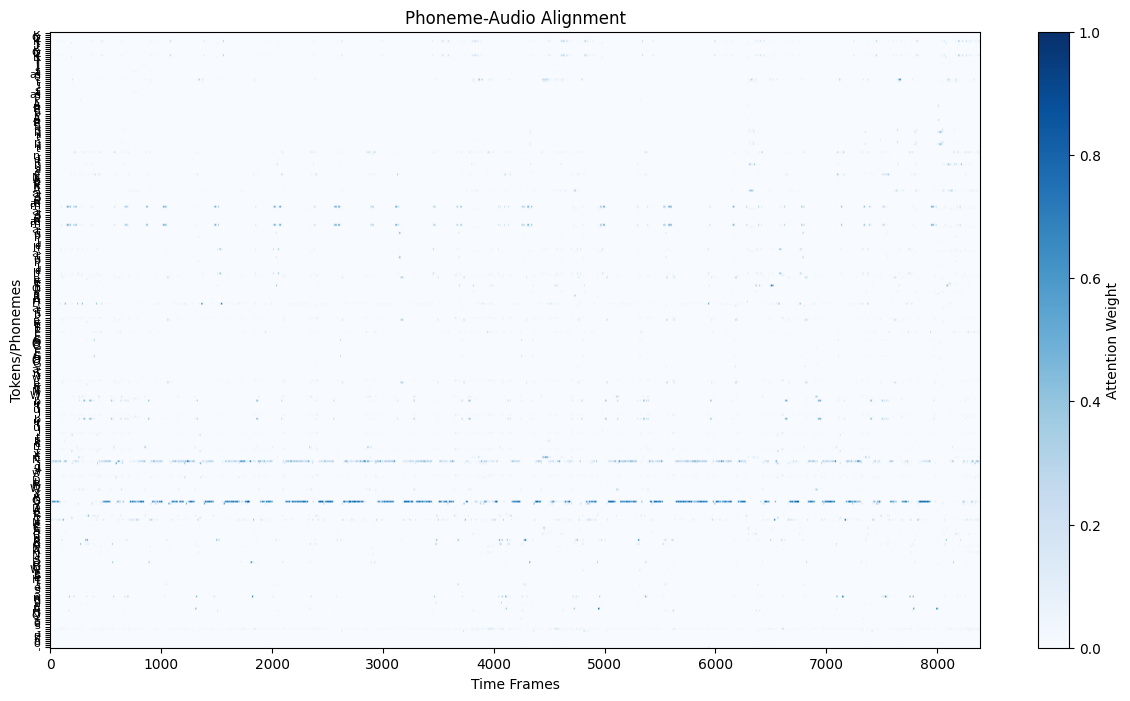


Alignment extraction completed!


In [ ]:
# get alignments results

import matplotlib.pyplot as plt
import numpy as np

def extract_phoneme_alignments(attn_soft_tensor, text_tokens, aligner, audio_data, orig_sr):
    """
    Extract phoneme-level alignment results from the attention matrices.
    
    Args:
        attn_soft_tensor: Soft attention tensor from the aligner
        text_tokens: Tokenized text (can be tensor or list)
        aligner: The aligner model
        audio_data: Original audio data
        orig_sr: Original sample rate
    
    Returns:
        list: Phoneme alignment results with timing information
    """
    # Convert tensors to numpy for easier processing
    attention = attn_soft_tensor.cpu().detach().numpy().squeeze()  # Remove batch dimension
    
    # Handle text_tokens whether it's a tensor or list
    if isinstance(text_tokens, torch.Tensor):
        text_tokens = text_tokens.squeeze().cpu().numpy().tolist()
    elif isinstance(text_tokens, np.ndarray):
        text_tokens = text_tokens.tolist()
    # If it's already a list, use as is
    
    # Get the tokenizer to convert tokens back to text/phonemes
    tokenizer = aligner.tokenizer
    
    # Convert token IDs back to tokens/phonemes
    token_strings = []
    for token_id in text_tokens:
        if hasattr(tokenizer, 'ids_to_tokens'):
            token_str = tokenizer.ids_to_tokens([token_id])[0]
        else:
            # Fallback method
            token_str = tokenizer.decode([token_id])
        token_strings.append(token_str)
    
    print(f"Text tokens: {token_strings}")
    print(f"Attention matrix shape: {attention.shape}")
    
    # Calculate frame-to-time mapping
    # Assuming the model uses hop_length for frame advancement
    hop_length = getattr(aligner.preprocessor, 'hop_length', 256)  # Default hop length
    frame_duration = hop_length / orig_sr  # Duration per frame in seconds
    
    # Extract alignment information
    alignments = []
    
    # For each phoneme/token, find the most attended frames
    for i, token in enumerate(token_strings):
        if i < attention.shape[1]:  # Make sure we don't exceed matrix dimensions
            # Get attention weights for this token across all time frames
            token_attention = attention[:, i]
            
            # Find frames with highest attention (above threshold)
            threshold = np.max(token_attention) * 0.3  # 30% of max attention
            active_frames = np.where(token_attention > threshold)[0]
            
            if len(active_frames) > 0:
                # Calculate timing
                start_frame = active_frames[0]
                end_frame = active_frames[-1]
                start_time = start_frame * frame_duration
                end_time = (end_frame + 1) * frame_duration
                duration = end_time - start_time
                
                # Calculate confidence (average attention weight)
                confidence = np.mean(token_attention[active_frames])
                
                alignment_info = {
                    'token': token,
                    'token_index': i,
                    'start_time': start_time,
                    'end_time': end_time,
                    'duration': duration,
                    'confidence': confidence,
                    'start_frame': start_frame,
                    'end_frame': end_frame,
                    'attention_weights': token_attention
                }
                
                alignments.append(alignment_info)
                
                print(f"Token '{token}': {start_time:.3f}s - {end_time:.3f}s (duration: {duration:.3f}s, confidence: {confidence:.3f})")
    
    return alignments

def visualize_alignment(attn_soft_tensor, text_tokens, aligner, save_path=None):
    """
    Visualize the alignment matrix as a heatmap.
    
    Args:
        attn_soft_tensor: Soft attention tensor from the aligner
        text_tokens: Tokenized text (can be tensor or list)
        aligner: The aligner model
        save_path: Optional path to save the visualization
    """
    attention = attn_soft_tensor.cpu().detach().numpy().squeeze()
    
    # Handle text_tokens whether it's a tensor or list
    if isinstance(text_tokens, torch.Tensor):
        text_tokens = text_tokens.squeeze().cpu().numpy().tolist()
    elif isinstance(text_tokens, np.ndarray):
        text_tokens = text_tokens.tolist()
    # If it's already a list, use as is
    
    # Get token strings
    tokenizer = aligner.tokenizer
    token_strings = []
    for token_id in text_tokens:
        if hasattr(tokenizer, 'ids_to_tokens'):
            token_str = tokenizer.ids_to_tokens([token_id])[0]
        else:
            token_str = tokenizer.decode([token_id])
        token_strings.append(token_str)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(attention.T, aspect='auto', origin='lower', cmap='Blues')
    plt.colorbar(label='Attention Weight')
    plt.xlabel('Time Frames')
    plt.ylabel('Tokens/Phonemes')
    plt.title('Phoneme-Audio Alignment')
    
    # Set y-axis labels to show tokens
    plt.yticks(range(len(token_strings)), token_strings, fontsize=8)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Extract phoneme-level alignments
print("Extracting phoneme-level alignment results...")
print("=" * 60)

# Fix: text_tokens is already a list, no need to squeeze/convert
if isinstance(text_tokens, torch.Tensor):
    text_tokens_list = text_tokens.squeeze().cpu().numpy()
else:
    text_tokens_list = text_tokens

alignments = extract_phoneme_alignments(
    attn_soft_tensor, 
    text_tokens_list, 
    aligner, 
    audio_data, 
    orig_sr
)

print("\n" + "=" * 60)
print("PHONEME ALIGNMENT SUMMARY")
print("=" * 60)

total_duration = len(audio_data) / orig_sr
print(f"Total audio duration: {total_duration:.3f} seconds")
print(f"Number of aligned tokens: {len(alignments)}")

# Create detailed alignment report
for i, alignment in enumerate(alignments):
    print(f"\n{i+1:2d}. Phoneme/Token: '{alignment['token']}'")
    print(f"    Time: {alignment['start_time']:.3f}s - {alignment['end_time']:.3f}s")
    print(f"    Duration: {alignment['duration']:.3f}s")
    print(f"    Confidence: {alignment['confidence']:.3f}")
    print(f"    Frames: {alignment['start_frame']} - {alignment['end_frame']}")

# Visualize the alignment
print("\nGenerating alignment visualization...")
# Fix: Handle text_tokens properly for visualization
if isinstance(text_tokens, torch.Tensor):
    text_tokens_for_viz = text_tokens.squeeze().cpu().numpy()
else:
    text_tokens_for_viz = text_tokens

visualize_alignment(attn_soft_tensor, text_tokens_for_viz, aligner)

# Save alignment results for further processing
alignment_results = {
    'transcript': transcript,
    'alignments': alignments,
    'total_duration': total_duration,
    'sample_rate': orig_sr
}

print("\nAlignment extraction completed!")

In [47]:
def analyze_phoneme_timing(alignments, expected_phonemes=None):
    """
    Analyze phoneme timing patterns for potential pronunciation errors.
    
    Args:
        alignments: List of alignment dictionaries from extract_phoneme_alignments
        expected_phonemes: Optional list of expected phonemes for comparison
    
    Returns:
        dict: Analysis results with potential issues
    """
    analysis = {
        'timing_anomalies': [],
        'confidence_issues': [],
        'duration_analysis': {},
        'recommendations': []
    }
    
    if not alignments:
        return analysis
    
    # Calculate statistics
    durations = [a['duration'] for a in alignments]
    confidences = [a['confidence'] for a in alignments]
    
    mean_duration = np.mean(durations)
    std_duration = np.std(durations)
    mean_confidence = np.mean(confidences)
    
    analysis['duration_analysis'] = {
        'mean_duration': mean_duration,
        'std_duration': std_duration,
        'mean_confidence': mean_confidence,
        'total_phonemes': len(alignments)
    }
    
    # Detect anomalies
    duration_threshold = mean_duration + 2 * std_duration  # 2 standard deviations
    confidence_threshold = mean_confidence * 0.7  # 70% of mean confidence
    
    for i, alignment in enumerate(alignments):
        # Check for unusually long phonemes (potential articulation issues)
        if alignment['duration'] > duration_threshold:
            analysis['timing_anomalies'].append({
                'phoneme': alignment['token'],
                'index': i,
                'duration': alignment['duration'],
                'expected_max': duration_threshold,
                'issue_type': 'prolonged_phoneme'
            })
        
        # Check for low confidence alignments (potential mispronunciation)
        if alignment['confidence'] < confidence_threshold:
            analysis['confidence_issues'].append({
                'phoneme': alignment['token'],
                'index': i,
                'confidence': alignment['confidence'],
                'expected_min': confidence_threshold,
                'issue_type': 'low_confidence'
            })
    
    # Generate recommendations
    if analysis['timing_anomalies']:
        analysis['recommendations'].append(
            f"Found {len(analysis['timing_anomalies'])} phonemes with unusual duration. "
            "Consider checking pronunciation speed and articulation clarity."
        )
    
    if analysis['confidence_issues']:
        analysis['recommendations'].append(
            f"Found {len(analysis['confidence_issues'])} phonemes with low alignment confidence. "
            "These may indicate pronunciation errors or unclear articulation."
        )
    
    return analysis

def compare_with_reference_phonemes(alignments, reference_phonemes):
    """
    Compare aligned phonemes with reference pronunciation.
    
    Args:
        alignments: List of alignment dictionaries
        reference_phonemes: List of expected phonemes
    
    Returns:
        dict: Comparison results
    """
    aligned_phonemes = [a['token'] for a in alignments]
    
    comparison = {
        'aligned_phonemes': aligned_phonemes,
        'reference_phonemes': reference_phonemes,
        'matches': 0,
        'mismatches': [],
        'missing_phonemes': [],
        'extra_phonemes': []
    }
    
    # Simple comparison (you might want to implement more sophisticated phoneme matching)
    min_length = min(len(aligned_phonemes), len(reference_phonemes))
    
    for i in range(min_length):
        if aligned_phonemes[i] == reference_phonemes[i]:
            comparison['matches'] += 1
        else:
            comparison['mismatches'].append({
                'position': i,
                'aligned': aligned_phonemes[i],
                'expected': reference_phonemes[i]
            })
    
    # Check for missing or extra phonemes
    if len(reference_phonemes) > len(aligned_phonemes):
        comparison['missing_phonemes'] = reference_phonemes[len(aligned_phonemes):]
    elif len(aligned_phonemes) > len(reference_phonemes):
        comparison['extra_phonemes'] = aligned_phonemes[len(reference_phonemes):]
    
    comparison['accuracy'] = comparison['matches'] / max(len(aligned_phonemes), len(reference_phonemes))
    
    return comparison

def generate_error_report(alignments, reference_phonemes=None):
    """
    Generate a comprehensive error detection report.
    
    Args:
        alignments: List of alignment dictionaries
        reference_phonemes: Optional reference phonemes for comparison
    
    Returns:
        dict: Complete error analysis report
    """
    report = {
        'timestamp': np.datetime64('now'),
        'total_phonemes': len(alignments),
        'timing_analysis': None,
        'phoneme_comparison': None,
        'overall_score': 0,
        'detailed_feedback': []
    }
    
    # Analyze timing patterns
    report['timing_analysis'] = analyze_phoneme_timing(alignments)
    
    # Compare with reference if provided
    if reference_phonemes:
        report['phoneme_comparison'] = compare_with_reference_phonemes(alignments, reference_phonemes)
        
        # Calculate overall score
        timing_score = max(0, 1 - len(report['timing_analysis']['timing_anomalies']) / len(alignments))
        confidence_score = max(0, 1 - len(report['timing_analysis']['confidence_issues']) / len(alignments))
        accuracy_score = report['phoneme_comparison']['accuracy']
        
        report['overall_score'] = (timing_score + confidence_score + accuracy_score) / 3
        
        # Generate detailed feedback
        if report['phoneme_comparison']['mismatches']:
            for mismatch in report['phoneme_comparison']['mismatches']:
                report['detailed_feedback'].append(
                    f"Position {mismatch['position']}: Said '{mismatch['aligned']}' "
                    f"instead of '{mismatch['expected']}'"
                )
    
    return report

# Example usage with the alignment results
print("\n" + "=" * 60)
print("PHONEME ERROR DETECTION ANALYSIS")
print("=" * 60)

# Analyze the alignments
timing_analysis = analyze_phoneme_timing(alignments)

print(f"\nDuration Analysis:")
print(f"- Mean phoneme duration: {timing_analysis['duration_analysis']['mean_duration']:.3f}s")
print(f"- Standard deviation: {timing_analysis['duration_analysis']['std_duration']:.3f}s")
print(f"- Mean confidence: {timing_analysis['duration_analysis']['mean_confidence']:.3f}")

if timing_analysis['timing_anomalies']:
    print(f"\nTiming Anomalies Found ({len(timing_analysis['timing_anomalies'])}):")
    for anomaly in timing_analysis['timing_anomalies']:
        print(f"- Phoneme '{anomaly['phoneme']}' at position {anomaly['index']}: "
              f"Duration {anomaly['duration']:.3f}s (expected max: {anomaly['expected_max']:.3f}s)")

if timing_analysis['confidence_issues']:
    print(f"\nConfidence Issues Found ({len(timing_analysis['confidence_issues'])}):")
    for issue in timing_analysis['confidence_issues']:
        print(f"- Phoneme '{issue['phoneme']}' at position {issue['index']}: "
              f"Confidence {issue['confidence']:.3f} (expected min: {issue['expected_min']:.3f})")

if timing_analysis['recommendations']:
    print(f"\nRecommendations:")
    for rec in timing_analysis['recommendations']:
        print(f"- {rec}")

print("\nAlignment analysis completed!")


PHONEME ERROR DETECTION ANALYSIS

Duration Analysis:
- Mean phoneme duration: 22.193s
- Standard deviation: 18.288s
- Mean confidence: 0.125

Confidence Issues Found (179):
- Phoneme 'ˌ' at position 1: Confidence 0.006 (expected min: 0.087)
- Phoneme 'o' at position 2: Confidence 0.083 (expected min: 0.087)
- Phoneme 'ˈ' at position 4: Confidence 0.004 (expected min: 0.087)
- Phoneme 'k' at position 5: Confidence 0.000 (expected min: 0.087)
- Phoneme 'e' at position 6: Confidence 0.000 (expected min: 0.087)
- Phoneme 'ɪ' at position 7: Confidence 0.028 (expected min: 0.087)
- Phoneme 'ˈ' at position 10: Confidence 0.000 (expected min: 0.087)
- Phoneme 's' at position 11: Confidence 0.000 (expected min: 0.087)
- Phoneme 'o' at position 12: Confidence 0.000 (expected min: 0.087)
- Phoneme 'ʊ' at position 13: Confidence 0.000 (expected min: 0.087)
- Phoneme 'Y' at position 15: Confidence 0.002 (expected min: 0.087)
- Phoneme 'O' at position 16: Confidence 0.001 (expected min: 0.087)
- Ph

In [ ]:
import numpy as np
import re

def levenshtein_alignment(seq1, seq2):
    '''
    Compute alignment between two sequences using dynamic programming (Levenshtein distance).
    Returns the aligned pairs (with None for insertions/deletions).
    '''
    n, m = len(seq1), len(seq2)
    dp = np.zeros((n+1, m+1), dtype=int)
    for i in range(n+1): dp[i,0] = i
    for j in range(m+1): dp[0,j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if seq1[i-1] == seq2[j-1] else 1
            dp[i,j] = min(
                dp[i-1,j] + 1,
                dp[i,j-1] + 1,
                dp[i-1,j-1] + cost
            )
    # Backtrack to get alignment
    i, j = n, m
    aligned = []
    while i > 0 or j > 0:
        if i > 0 and j > 0 and (dp[i,j] == dp[i-1,j-1] + (seq1[i-1] != seq2[j-1])):
            aligned.append((seq1[i-1], seq2[j-1]))
            i -= 1; j -= 1
        elif i > 0 and (dp[i,j] == dp[i-1,j] + 1):
            aligned.append((seq1[i-1], None))
            i -= 1
        else:
            aligned.append((None, seq2[j-1]))
            j -= 1
    aligned.reverse()
    return aligned

def extract_actual_phonemes_per_word(alignments, transcript):
    '''
    Attempt to split the aligned phoneme sequence into words,
    assuming alignments are in order and transcript words are in order.
    This is a heuristic and may not be perfect.
    '''
    # Clean transcript and split to words
    words = re.sub(r'[^\w\s]', '', transcript.lower()).split()
    # Get all phonemes from alignments
    all_phonemes = [a['token'] for a in alignments]
    # Heuristic: split phonemes evenly per word length
    total_chars = sum(len(w) for w in words)
    phoneme_counts = [max(1, int(len(w)/total_chars * len(all_phonemes))) for w in words]
    # Adjust to match total phonemes
    diff = len(all_phonemes) - sum(phoneme_counts)
    for i in range(abs(diff)):
        idx = i % len(phoneme_counts)
        phoneme_counts[idx] += 1 if diff > 0 else -1
    # Now split
    actual_phonemes_per_word = []
    idx = 0
    for count in phoneme_counts:
        actual_phonemes_per_word.append(all_phonemes[idx:idx+count])
        idx += count
    return words, actual_phonemes_per_word

def compare_phonemes_per_word(transcript, lexicon, alignments):
    '''
    For each word, compare expected and actual phonemes using DP.
    Output words with differences and show the differing phonemes.
    '''
    words, actual_phonemes_per_word = extract_actual_phonemes_per_word(alignments, transcript)
    print(f"{'Word':<15} | {'Expected':<30} | {'Actual':<30} | Differences")
    print('-'*90)
    for i, word in enumerate(words):
        expected_phonemes = get_phonemes_enhanced(word, lexicon).split()
        actual_phonemes = actual_phonemes_per_word[i] if i < len(actual_phonemes_per_word) else []
        alignment = levenshtein_alignment(expected_phonemes, actual_phonemes)
        # Find if there are any mismatches
        diffs = [(e,a) for e,a in alignment if e != a]
        if diffs:
            exp_str = ' '.join(expected_phonemes)
            act_str = ' '.join(actual_phonemes)
            diff_str = ', '.join([f"({e or '_'}→{a or '_'})" for e,a in diffs])
            print(f"{word:<15} | {exp_str:<30} | {act_str:<30} | {diff_str}")

# Example usage:
# compare_phonemes_per_word(transcript, cmudict_lexicon, alignments)